<a href="https://colab.research.google.com/github/nyoons/ESAA/blob/main/%EC%8A%A4%ED%84%B0%EB%94%94_1%EC%B0%A8_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#분류

##01. 분류의 개요
배깅 - 랜덤 포레스트

부스팅 - 그래디언트 부스팅, XGB, LGBM

##02. 결정 트리

쉽고 직관적, 사전 가공 영향도가 크지 않음

하지만 과적합으로 성능 떨어짐. 트리의 크기를 사전에 제한하는 튜닝 필요.

DecisionTreeClassifier의 파라미터
- min_samples_split : 노드 분할하기 위한 최소한의 샘플 데이터 수, 과적합 제어
- min_samples_leaf : 말단 노드가 되기 위한 최소한의 샘플 데이터 수
- max_features : 최적의 분할을 위해 고려할 최대 피처 수, 디폴트는 모든 피처
- max_depth
- max_leaf_nodes

###결정 트리 실습 - 사용자 행동 인식 데이터 세트
피처명 보니 인체의 움직임과 관련된 속성의 평균/표준편차가 x,y,z축 값으로 되어 있음.

In [ ]:
#중복되는 피처명을 _1, _2 처리하는 함수 생성
def get_new_feature_name_df(old_feature_name_df):
  feature_dup_df=pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
  feature_dup_df=feature_dup_df.reset_index()
  new_feature_name_df=pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
  new_feature_name_df['column_name']=new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1]>0 else x[0], axis=1)
  new_feature_name_df=new_feature_name_df.drop(['index'], axis=1)
  return new_feature_name_df

In [ ]:
#get_humans_dataset() 정의
import pandas as pd

def get_human_dataset():
  feature_name_df=pd.read_csv('features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])
  new_feature_name_df=get_new_feature_name_df(feature_name_df)
  feature_name=new_feature_name_df.iloc[:,1].values.tolist()
  X_train=pd.read_csv('X_train.txt', sep='\s+', names=feature_name)
  X_test=pd.read_csv('X_test.txt', sep='\s+', names=feature_name)
  y_train=pd.read_csv('y_train.txt', sep='\s+', header=None, names=['action'])
  y_test=pd.read_csv('y_test.txt', sep='\s+', header=None, names=['action'])
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test=get_human_dataset()

In [ ]:
#피처가 모두 숫자형이라 별도의 카테고리 인코딩은 필요 없다.

#동작 예측 분류 수행해보자.
#먼저 하이퍼 파라미터는 모두 디폴트로 수행하고, 이때의 하이퍼 파라미터 값을 추출해보자.
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_clf=DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred=dt_clf.predict(X_test)
accuracy=accuracy_score(y_test, pred)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

#하이퍼 파라미터 추출
print('결정 트리의 기본 하이퍼 파라미터:\n', dt_clf.get_params())

결정 트리 예측 정확도: 0.8548
결정 트리의 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


In [ ]:
#트리 깊이가 주는 영향을 보자. max_depth.
from sklearn.model_selection import GridSearchCV

params={'max_depth':[6,8,10,12,16,20,24]}
grid_cv=GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치: 0.8513
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 16}


- 트리 깊이가 주는 영향 : 깊어진 트리는 학습 데이터 세트에는 올바른 예측 결과를 가져오나, 검증 데이터 세트에는 과적합으로 성능 저하 유발

In [ ]:
#이제는 max_depth와 min_samples_split을 같이 변경하며 정확도 성능 튜닝
params={'max_depth':[8,12,16,20], 'min_samples_split':[16,24]}

grid_cv=GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
GridSearchCV 최고 평균 정확도 수치: 0.8549
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_split': 16}


- 디폴트일 때 보다 max_depth와 min_samples_split 하이퍼 파라미터 최적화를 통해 성능 향상 가능

##03. 앙상블 학습
- 보팅 : 투표를 통해, 일반적으로 서로 다른 알고리즘 결합
- 배깅 : 투표를 통해, 같은 분류기지만 데이터 샘플링 다른 학습, 랜덤포레스트
- 부스팅 : 여러개 분류기가 순차적 학습, 가중치 부여

-

- 하드 보팅 : 다수결
- 소프트 보팅 : 모두 더해 평균, 일반적!

##04. 랜덤 포레스트
배깅이지만 개별 트리가 학습하는 데이터를 일부가 중첩되게 샘플링함 = 부트스트래핑

단점 : 하이퍼 파라미터 많고, 튜닝 시간이 많이 소모된다는 것

###랜덤 포레스트 실습 - 사용자 행동 인식 데이터 세트

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test=get_human_dataset()

rf_clf=RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred=rf_clf.predict(X_test)
accuracy=accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9253


- 결정 트리보다 확실히 좋다!

In [ ]:
#랜덤 포레스트의 하이퍼 파라미터 튜닝 진행해보자
#시간 절약 위해 n_estimators=100, cv=2로 먼저 진행
from sklearn.model_selection import GridSearchCV

params={'n_estimators':[100], 'max_depth':[6,8,10,12], 'min_samples_leaf':[8,12,18], 'min_samples_split':[8,16,20]}

rf_clf=RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv=GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9180


In [ ]:
#n_estimators 높이고 최적화 하이퍼 파라미터로 적용해보자
rf_clf1=RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=8, min_samples_split=8, random_state=0)
rf_clf1.fit(X_train, y_train)
pred=rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도: 0.9165


##05. GBM

###GBM 실습 - 사용자 행동 인식 데이터 세트

In [ ]:
#from sklearn.ensemble import GradientBoostingClassifier
#import time
#import warnings
#warnings.filterwarnings('ignore')

#X_train,X_test, y_train, y_test=get_human_dataset()

#GBM 사용 시 수행시간이 얼마나 걸리는지도 보자
#start_time=time.time()

#gb_clf=GradientBoostingClassifier(random_state=0)
#gb_clf.fit(X_train, y_train)
#gb_pred=gb_clf.predict(X_test)
#gb_accuracy=accuracy_score(y_test, gb_pred)

#print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
#print('GBM 수행 시간: {0:.1f}초'.format(time.time()-start_time()))

- 시간이 너무 오래 걸려 # 처리.
- 교재에 따르면 랜덤 포레스트보다 조금 나은 성능! 일반적으로는 GBM이 랜덤 포레스트보다 낫다.
- 그러나 수행 시간, 하이퍼 파라미터 튜닝 노력이라는 단점... 특히 수행시간이 오래걸림.

In [ ]:
#하이퍼 파라미터 최적화해보자.

#from sklearn.model_selection import GridSearchCV

#parmas={'n_estimatiors':[100,500], 'learning_rate':[0.05, 0.1]}

#grid_cv=GridSearchCV(gb_clf, param_grid=params, cv=2, verbose=1)
#grid_cv.fit(X_train, y_train)
#print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
#print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

- 수행 시간이 너무 오래 걸려 우선 # 처리
- 교재에 따르면 learning_rate=0.05, n_estimators=500일 때 정확도가 90.1%로 최고.
- GBM은 확실히 성능은 좋지만 시간이 문제이다.

##06. XGBoost

앞에서 봤듯 GBM은 시간이 너무 오래 걸림. 따라서 GBM 기반의 알고리즘들이 많이 만들어지고 있는데 그 중 각광 받는 두 가지 패키지가 XGB와 LGBM.

특히 XGB는 GBM의 느린 수행 시간과 과적합 규제 부재 등의 문제를 해결했다.

초기의 독자적 XGBoost 기반의 XGB는 파이썬 래퍼 XGB 모듈, 사이킷런과 연동되는 모듈은 사이킷런 래퍼 XGB 모듈이라고 지칭. 

###XGB 실습 - 위스콘신 유방암 예측

In [ ]:
import xgboost as xgb #이게 사이킷런 아니고 파이썬 래퍼 XGB 방식
from xgboost import plot_importance #xgboost 패키지는 피처 중요도 시각화해주는 모듈도 제공한다!
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset=load_breast_cancer()
X_features=dataset.data
y_label=dataset.target

cancer_df=pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']=y_label

- 기본적으로 살펴보기에 악성과 양성이 아주 비대칭적이지는 않은 것 같다.

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156)

- 여기서 파이썬 래퍼 XGB가 사이킷런과 다른 점은 학습용과 테스트용 데이터 세트를 위해 별도의 객체인 DMatrix를 생성한다는 것. 사이킷런을 주로 사용할 예정이라 자세히 하지는 않겠음. dtrain과 dtest를 지정하고 하이퍼 파라미터를 설정하여 학습을 수행하면 된다. 교재에서 파이썬 래퍼 XGB의 하이퍼 파라미터로 설정한 것은 max_depth=3, eta=0.1, objective=binary:logistic, eval_metric=logloss, early_stoppings=100. 최적 파라미터는 cv() API로 제공한다. 
- 참고로 **early_stopping_rounds를 설정하기 위해선 반드시 eval_set과 eval_metric이 함께 설정**되어야 한다.
- 교재에 따르면 이렇게 학습했을 경우 파이썬 래퍼 XGB의 정확도는 약 0.9737
- 사이킷런으로 넘어가면, 파이썬 래퍼 XGB에서 사용하던 하이퍼 파라미터 몇 개의 이름이 변경된다. eta- > learning_rate, sub_sample -> subsample, lambda -> reg_lambda, alpha -> reg_alpha

In [ ]:
#사이킷런 래퍼 XGB로 계속해보자.
from xgboost import XGBClassifier

xgb=XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb.fit(X_train, y_train)
preds=xgb.predict(X_test)
preds_proba=xgb.predict_proba(X_test)[:,1]

- get_clf_eval(y_test, preds, pred_proba)로 보면 정확도는 0.9737 즉, 파이썬 래퍼 XGB와 동일한 결과이다. 

In [ ]:
#사이킷런에서도 조기 중단 실행 가능
xgb=XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals=[(X_test, y_test)] #원래 이렇게 하면 안됨! test는 알려지지 않은 데이터임을 유의
xgb.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
preds=xgb.predict(X_test)
pred_proba=xgb.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

- 교재에 따르면 조기 중단으로 학습된 예측 성능은 약간 저조하나 큰 차이는 없다. 정확도 0.965 정도. 하지만 조기 중단을 너무 급하게 하면 당연히 안되겠지.

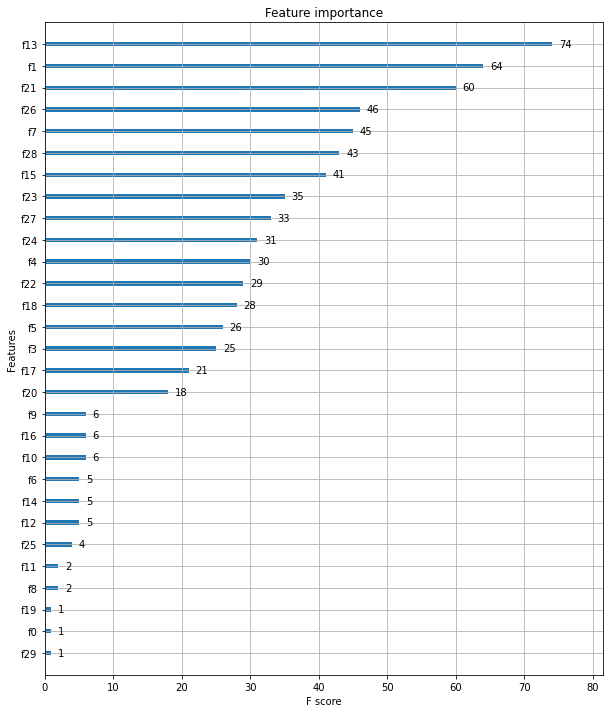

In [ ]:
#사이킷런도 시각화 가능하다!
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax=plt.subplots(figsize=(10,12))
plot_importance(xgb, ax=ax)

##07. LGBM
xgb도 여전히 시간이 오래 걸림. 시간 문제를 해결한 lgbm! lgbm은 균형 트리 분할이 아닌 리프 중심 트리 분할을 사용한다. 비대칭적인 규칙 트리가 생성되는 것. 그래서 하이퍼 파라미터에서 **max_depth를 매우 크게 가지는 등의 특성**이 있다.

하이퍼 파라미터 조정은 num_leaves의 개수를 중심으로 min_child_samples, max_depth를 함께 조정하며 모델의 복잡도를 줄이는 방식이 기본 튜닝 방안이다.

###LGBM 실습 - 위스콘신 유방암 예측

In [ ]:
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset=load_breast_cancer()
ftr=dataset.data
target=dataset.target

X_train, X_test, y_train, y_test=train_test_split(ftr, target, test_size=0.2, random_state=156)

lgbm=LGBMClassifier(n_estimators=400)

#lgbm도 조기 중단이 수행 가능하다!
evals=[(X_test, y_test)]
lgbm.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
preds=lgbm.predict(X_test)
pred_proba=lgbm.predict_proba(X_test)[:,1]

[1]	valid_0's binary_logloss: 0.565079	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.507451	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355846	valid_0's binary_logloss: 0.355846
[7]	valid_0's binary_logloss: 0.330897	valid_0's binary_logloss: 0.330897
[8]	valid_0's binary_logloss: 0.306923	valid_0's binary_logloss: 0.306923
[9]	valid_0's binary_logloss: 0.28776	valid_0's binary_logloss: 0.28776
[10]	valid_0's binary_logloss: 0.26917	valid_0's binary_logloss: 0.26917
[11]	valid_0's binary_logloss: 0.250954	valid_0's binary_logloss: 0.250954
[12]	valid_0's binary_logloss: 0.23847	valid_0's binary_logloss: 0.23847
[13]	valid_0's binary_logloss: 0.225865	valid_0's bi

- 교재에 따르면 get_clf_eval(y_test, preds, pred_proba)로 얻은 정확도는 0.9474로 xgb보다는 살짝 낮으나 큰 의미는 없다.
- xgb와 동일한 방식으로 피처 중요도 시각화도 가능하다.

##08. 분류 실습 - 캐글 산탄데르 고객 만족 예측 (간단히 보기)
- 만족/불만족이 비대칭인 데이터이므로 정확도보단 ROC-AUC가 더 적합하겠군.

**1. 데이터 전처리**
- 모든 피처가 숫자형, null은 없음
- 하지만 불만족이 4%에 불과함.
- var3 피처에는 null을 -999999로 넣은 값이 있음 -> 그 피처에서 최빈값인 2로 대체
- X_features와 y_labels 저장 후 train_test_split 진행. 이 때 **불만족 비율이 유지되었는지 꼭 확인**하기!

**2. XGB와 LGBM 학습하고 하이퍼 파라미터 튜닝**



##09. 분류 실습 - 캐글 신용카드 사기 검출 (자세히 보기)
- 굉장히 불균형한 데이터!! 언더 샘플링 또는 오버 샘플링이 필요해보인다. SMOTE를 사용할 것이다.



In [ ]:
#실습에 앞서 get_clf_eval 정의해두기!

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion=confusion_matrix(y_test, pred)
  accuracy=accuracy_score(y_test, pred)
  precision=precision_score(y_test, pred)
  recall=recall_score(y_test, pred)
  f1=f1_score(y_test, pred)
  roc_auc=roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

###**데이터 일차 가공**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df=pd.read_csv('creditcard.csv')

#결측값은 없고 모두 숫자형이다
#Time 피처는 의미 없으므로 제거할 것임

from sklearn.model_selection import train_test_split

# 인자로 입력 받은 dF를 복사한 뒤, time 칼럼 삭제하고 복사된 df를 반환하는 함수 만들자
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  df_copy.drop('Time', axis=1, inplace=True)
  return df_copy

#사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수 만들자
def get_train_test_dataset(df=None):
  df_copy=get_preprocessed_df(df)
  X_features=df_copy.iloc[:,:-1]
  y_target=df_copy.iloc[:,-1]
  X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test=get_train_test_dataset(card_df)

- 비율 문제 없이 잘 분할 되었는지 확인하기! -> 잘 분할됨.

###**일차 가공한 모델 학습/예측/평가**

1. 로지스틱 회귀

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf=LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred=lr_clf.predict(X_test)
lr_pred_proba=lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85281    14]
 [   60    88]]
정확도: 0.9991, 정밀도: 0.8627, 재현율: 0.5946, F1:0.7040, AUC:0.9639


- 재현율이 0.6 정도, AUC가 0.96 정도.

2. LGBM

In [ ]:
#앞으로 몇 번 반복할거니까 학습/예측/평가를 수행해주는 함수를 생성하자.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
  model.fit(ftr_train, tgt_train)
  pred=model.predict(ftr_test)
  pred_proba=model.predict_proba(ftr_test)[:,1]
  get_clf_eval(tgt_test, pred, pred_proba)

In [ ]:
#이제 lgbm 해보자
from lightgbm import LGBMClassifier

lgbm_clf=LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False) #불균형한 분포를 가지므로 boost_from_average=False로 설정해야한다
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568, F1:0.8421, AUC:0.9797


- 재현율이 0.75 정도, AUC가 0.97 정도로 로지스틱 회귀보다는 괜찮아보인다.

3. XGB
- 교재에는 없지만 가능한지 돌려보자

In [ ]:
#from xgboost import XGBClassifier

#xgb_clf=XGBClassifier(n_estimators=1000,learning_rate=0.02, max_depth=7, min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)
#get_model_train_eval(xgb_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

- 시간이 너무 오래 걸린다. 데이터가 매우 커서 그런듯 하다. 만약 xgb를 사용하면 이런식으로 사용할 수 있다. 코드는 산탄데르 고객 만족 데이터 실습에서 참고.

###**데이터 분포도 변환 후 학습/예측/평가**
- Amount 피처가 꼬리가 긴 형태의 분포 곡선을 가지고 있다. 변환해볼까.

**정규 분포 형태로?**

In [ ]:
from sklearn.preprocessing import StandardScaler

#아까 정의했던 함수 StandardScaler로 amount 피처 값도 변환해주는 로직으로 수정하자!

def get_preprocessed_df(df=None):
  df_copy=df.copy()
  scaler=StandardScaler()
  amount_n=scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
  #변환된 amount를 Amount_Scaled로 피처명 변경 후 DF 맨 앞 칼럼으로 입력
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  #기존 time과 amount 피처 삭제
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  return df_copy

In [ ]:
#Amount를 정규 분포 형태로 변환 후 학습/예측/평가 수행하자
X_train, X_test, y_train, y_test=get_train_test_dataset(card_df)

1. 로지스틱 회귀

In [ ]:
lr_clf=LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, F1:0.7143, AUC:0.9702


2. LGBM

In [ ]:
lgbm_clf=LGBMClassifier(n_estimatiors=1000, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85151   144]
 [   85    63]]
정확도: 0.9973, 정밀도: 0.3043, 재현율: 0.4257, F1:0.3549, AUC:0.6085


- StandardScaler 성능이 딱히 좋지 않아보임

**로그 변환?**

In [ ]:
#amount 피처 값 로그 변환도 해주는 로직으로 수정하자!

def get_preprocessed_df(df=None):
  df_copy=df.copy()
  amount_n=np.log1p(df_copy['Amount'])
  #변환된 amount를 Amount_Scaled로 피처명 변경 후 DF 맨 앞 칼럼으로 입력
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  #기존 time과 amount 피처 삭제
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  return df_copy

In [ ]:
#Amount를 로그 변환 후 학습/예측/평가 수행하자
X_train, X_test, y_train, y_test=get_train_test_dataset(card_df)

1. 로지스틱 회귀

In [ ]:
lr_clf=LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1:0.7149, AUC:0.9727


2. LGBM

In [ ]:
lgbm_clf=LGBMClassifier(n_estimatiors=1000, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85106   189]
 [  144     4]]
정확도: 0.9961, 정밀도: 0.0207, 재현율: 0.0270, F1:0.0235, AUC:0.2758


- 심하게 왜곡된 데이터는 로그 변환이 괜찮아보임

###**이상치 제거 후 학습/예측/평가**
- 이상치를 제거하면 성능이 크게 향상됨

###**SMOTE 오버 샘플링 적용 후 학습/예측/평가**
- 반드시 학습 데이터 세트만 오버 샘플링을 해야 한다는 점을 주의

In [ ]:
pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from imblearn.over_sampling import SMOTE

smote=SMOTE(random_state=0)
X_train_over, y_train_over=smote.fit_sample(X_train, y_train)

AttributeError: ignored

- smote 적용 전 학습 데이터 세트보다 2배 가까이 증식됨
- 그리고 smote를 적용하니 0과 1의 분포가 동일하게 생성되었다.

1. 로지스틱 회귀

In [ ]:
lr_clf=LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

- 로지스틱의 경우 재현율은 크게 증가하나 정밀도가 너무 떨어짐. 예측을 지나치게 1로 한 것... -> smote로는 로지스틱은 사용 불가.

2. LGBM

In [ ]:
lgbm_clf=LGBMClassifier(n_estimatiors=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

- 이상치만 제거한 경우보다 재현율이 높아지기도 함! **SMOTE 적용시 재현율은 높아지나 정밀도는 낮아지는 것이 일반적**. 

##10. 스태킹 앙상블
- 여러 알고리즘을 결합한다는 것에서 배깅 및 부스팅과 공통점.
- 하지만 최종 메타 데이터 세트를 만들어 별도의 머신러닝 알고리즘으로 최종 학습을 수행하고 테스트 데이터를 기반으로 다시 최종 예측을 진행하는 방식.
- 현실에서는 잘 쓰이진 않지만 조금이라도 더 성능을 향상하고 싶을 때 사용,,

###기본 스태킹 모델

In [1]:
import numpy as np

#여기서 불러오는 애들이 개별 모델이 될 것임
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

#그리고 최종 모델은 로지스틱 회귀가 될 것임
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data=load_breast_cancer()

X_data=cancer_data.data
y_label=cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=0)

In [3]:
#개별 머신러닝 모델 생성
knn_clf=KNeighborsClassifier(n_neighbors=4)
rf_clf=RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf=DecisionTreeClassifier()
ada_clf=AdaBoostClassifier(n_estimators=100)

#스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final=LogisticRegression(C=10)

In [4]:
#개별 모델들 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [6]:
#학습된 개별 모델들이 각자 반환하는 예측 데이터를 생성하고 개별 모델의 정확도 측정
knn_pred=knn_clf.predict(X_test)
rf_pred=rf_clf.predict(X_test)
dt_pred=dt_clf.predict(X_test)
ada_pred=ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('RF 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('DT 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('ADA 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
RF 정확도: 0.9649
DT 정확도: 0.9123
ADA 정확도: 0.9561


- 이렇게 생성된 예측 데이터를 칼럼 레벨로 옆으로 붙여 피처 값으로 만들어 최종 모델인 로지스틱 회귀에서 다시 학습 데이터로 사용하는 것!

In [7]:
pred=np.array([knn_pred, rf_pred, dt_pred, ada_pred])
pred=np.transpose(pred)

lr_final.fit(pred, y_test)
final=lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도: 0.9737


- 확실히 위에 있던 개별 모델들보다 향상되었다.

###CV 세트 기반의 스태킹
- 과적합 개선 위함.
- 최종 모델을 위한 데이터 세트를 만들 때 교차 검증 기반으로 예측된 결과 데이터 세트를 이용

**스텝 1** : 개별 모델이 메타 모델을 위한 학습용 데이터와 테스트용 데이터를 생성

In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

#개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
  #지정된 n_folds 값으로 KFold 생성
  kf=KFold(n_splits=n_folds, shuffle=True, random_state=0)
  #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
  train_fold_pred=np.zeros((X_train_n.shape[0], 1))
  test_pred=np.zeros((X_test_n.shape[0], n_folds))
  print(model.__class__.__name__, 'model 시작')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
    print('\t 폴드 세트: ', folder_counter, '시작')
    X_tr=X_train_n[train_index]
    y_tr=y_train_n[train_index]
    X_te=X_test_n[valid_index]

    #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
    model.fit(X_tr, y_tr)
    #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
    train_fold_pred[valid_index, :]=model.predict(X_te).reshape(-1,1)
    #입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
    test_pred[:, folder_counter]=model.predict(X_test_n)

  #폴드 세트 내에서 원본 테스트 데이터 세트를 예측한 데이터를 평균하여 테스트 데이터로 생성
  test_pred_mean=np.mean(test_pred, axis=1).reshape(-1,1)

  #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
  return train_fold_pred, test_pred_mean

In [11]:
knn_train, knn_test=get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test=get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test=get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test=get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier model 시작
	 폴드 세트:  0 시작


IndexError: ignored

**스텝 2** : 각 모델별 학습 데이터와 테스트 데이터를 합치기만 하면 된다